<a id='top'></a>

# DSP using FFT and psd

This notebook will demonstrate some basic aspects related with digital signal processing using FFT and psd. It is mostly inspired by two LabVIEW white papers, [this one](http://www.ni.com/white-paper/4278/en/) and [this one](http://www.ni.com/white-paper/4541/en/). We will also take the oportunity to test different power spectrum estimation implementations from two common Python packages, [matplotlib.mlab](http://matplotlib.org/api/mlab_api.html) and [scipy.signal](https://scipy.github.io/devdocs/signal.html), following this [StackOverflow question](http://stackoverflow.com/questions/33286467/why-do-the-power-spectral-density-estimates-from-matplotlib-mlab-psd-and-scipy-s).

## Table of contents

[Preamble](#Preamble)

[Introduction](#Introduction)

[Sample signal](#Sample-signal)

[Fourier transform](#Fourier-transform)

[Power spectrum](#Power-spectrum)

[Power spectral density](#Power-spectral-density)

[Matplotlib package](#Matplotlib-package)

[Conclusions](#Conclusions)

[Odds and ends](#Odds-and-ends)

## Preamble

The computational environment set up for this Python notebook includes numpy and scipy for the numerical simulations, matplotlib and pandas for the plots:

In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)
for package in (np, sp, mpl, pd):
    print('{:.<15} {}'.format(package.__name__, package.__version__))

3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
numpy.......... 1.11.2
scipy.......... 0.18.1
matplotlib..... 1.5.3
pandas......... 0.19.2+0.g825876c.dirty


Furthermore, we will need the following special functions:

In [2]:
from numpy.fft import fft, fftfreq, rfft, rfftfreq, fftshift
from scipy.signal import periodogram, welch
from matplotlib.mlab import rms_flat, psd, detrend_none, window_hanning

[Back to top](#top)

## Introduction

The power spectral density of a digital signal can be estimated in several different ways, namely through:

1. The [periodogram](https://en.wikipedia.org/wiki/Periodogram)
2. The [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method)
3. The [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)

We will illustrate them below. However, before that we will have to set up a sample signal.

[Back to top](#top)

## Sample signal

For the purpose of illustration, in this notebook we will use a sample signal (in volt) composed of a small amplitude sine wave with an additive large amplitude random noise:

                    Max       Min      Mean       RMS
Random noise   0.499964 -0.499974  0.001130  0.291612
Sine wave      0.067000 -0.067000  0.000043  0.047378
Sample signal  0.564810 -0.563271  0.001173  0.294145


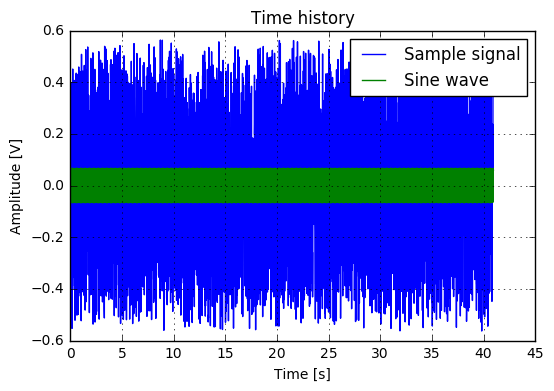

In [3]:
Ns = 4096 # number of samples
np.random.seed(1234) # random seed (for repeatability)
rn = np.random.random(Ns)-0.5 # zero mean random noise

Fs = 100 # sampling frequency
dt = 1./Fs # time discretisation
tt = np.arange(Ns)*dt # time sampling

A = 0.067 # sine wave amplitude
f = 10.24 # sine wave frequency
sw = A*np.sin(2*np.pi*f*tt) # sine wave

ss = sw+rn # sample signal
signals = (rn, sw, ss)
labels = ('Random noise', 'Sine wave', 'Sample signal')

v = [(np.max(v), np.min(v), np.mean(v), rms_flat(v)) for v in signals]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Min', 'Mean', 'RMS'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(tt, signals[v], label=labels[v])
ax.set_title('Time history')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid()

The sample signal time history plot shows that the sine wave is completely hidden by the additive random noise because of the difference in the amplitudes of both signals.

The theoretical **sine wave RMS value** is equal to its amplitude (A) divided by the square root of 2:

$$RMS(sine wave) = \frac{A}{\sqrt 2}$$

In [4]:
print('{:.6f}, {:.6f}'.format(df['RMS']['Sine wave'], A/np.sqrt(2)))

0.047378, 0.047376


For additive [orthogonal](https://en.wikipedia.org/wiki/Root_mean_square) signals, the RMS value of the total is equal to the square root of sum of squares (SRSS) of the parts.  Let us check that with the random noise and the sine wave against the sample signal:

In [5]:
SRSS = np.sqrt(df['RMS']['Random noise']**2 + df['RMS']['Sine wave']**2)
print('{:.6f}, {:.6f}'.format(SRSS, df['RMS']['Sample signal']))

0.295435, 0.294145


We are now ready to start processing these signals.

[Back to top](#top)

## Fourier transform

We will start processing these signals by taking their Fourier transform into the frequency domain. We will use the FFT algorithm, implemented in NumPy as the [fft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html) function, and normalise the result by the number of samples (Ns):

                    Max       Freq
Random noise   0.013170  20.922852
Sine wave      0.024192  10.229492
Sample signal  0.018681  10.229492


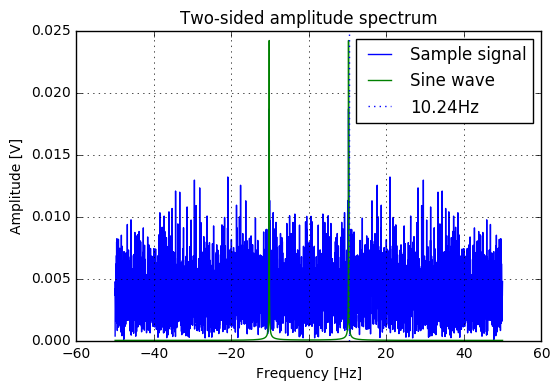

In [6]:
RN2 = fft(rn)/Ns
SW2 = fft(sw)/Ns
SS2 = fft(ss)/Ns
FT2 = (RN2, SW2, SS2)
freqs = fftfreq(Ns, d=1./Fs)

v = [(np.absolute(v[ix]), freqs[ix]) for v in FT2 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(fftshift(freqs), fftshift(np.absolute(FT2[v])), label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Two-sided amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid()

Several aspects are worth mentioning about these plots:

1. The amplitude spectra comprise both positive and negative frequencies, reason why it is called a **two-sided spectrum**;
2. They are symmetric about the origin, which stems from the fact that the Fourier transform of real signals is Hermitian;
3. The peak values occur at the same frequency, which is very close, but not equal, to the sine wave frequency. This issue is related to the frequency discretisation of the fft, which, in turn, depends on the length of the signal.

The theoretical peak value of a sine wave two-sided normalised amplitude spectrum is equal to the sine wave amplitude (A) divided by the double of the square root of 2:

$$|FT_{2-sided}| = \frac{A}{2 \cdot \sqrt 2}$$

In [7]:
print('{:.6f}, {:.6f}'.format(df['Max']['Sine wave'], A/(2*np.sqrt(2))))

0.024192, 0.023688


The difference between the actual and theoretical values will become smaller as the duration of the signals increases towards infinity. *This aspect, which also influences the frequency discretisation mentioned above, affects most of the numerical comparisons shown in this notebook*.

We will now take advantage of this symmetry property of the Fourier transform with real signals to compute only the non-negative frequency terms. There are two options to achieve that:

1. Truncate the FFT - basically, compute only the terms that are of interest;
2. Fold the FFT - compute the FFT ordinates as if they were [folded](http://www.staff.vu.edu.au/msek/FFT%20Folding%20Algorithm.pdf) about the Nyquist frequency to obtain a **one-sided spectrum**.

For the first one we will use the [rfft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html) function implemented in NumPy which gives the spectral components from DC up to the Nyquist frequency:

                    Max       Freq        DC
Random noise   0.013170  20.922852  0.001130
Sine wave      0.024192  10.229492  0.000043
Sample signal  0.018681  10.229492  0.001173


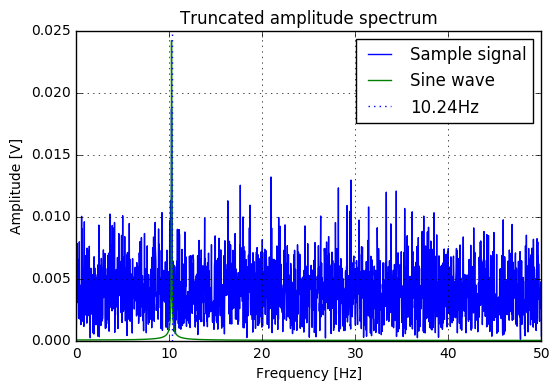

In [8]:
TRN = rfft(rn)/Ns
TSW = rfft(sw)/Ns
TSS = rfft(ss)/Ns
TFT = (TRN, TSW, TSS)
tfreqs = rfftfreq(Ns, d=1./Fs)

v = [(np.absolute(v[ix]), tfreqs[ix], np.absolute(v[0])) for v in TFT for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(tfreqs, np.absolute(TFT[v]), label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Truncated amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid()

As can be seen, these truncated amplitude spectra are exactly the same as the previous two-sided amplitude spectra, but were computed only for the non-negative frequency terms.

The one-sided spectra, on the other hand, are computed by taking the complex conjugate of the second half of the two-sided spectrum (the negative frequencies), reversing and adding it to the first half (to the corresponding positive frequencies). Better yet, multiply the truncated spectrum ordinates by two, with the only exceptions of the DC and Nyquist (if it exists) components:

                    Max       Freq        DC
Random noise   0.026340  20.922852  0.001130
Sine wave      0.048384  10.229492  0.000043
Sample signal  0.037361  10.229492  0.001173


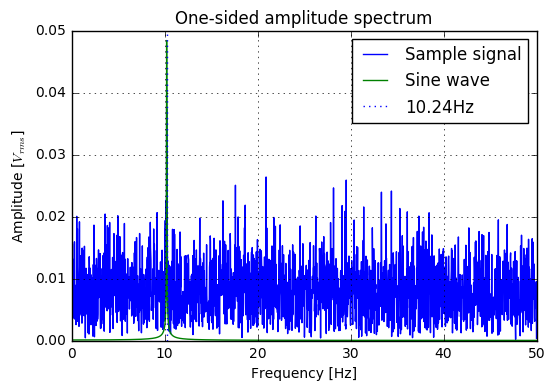

In [9]:
scale = 2.*np.ones_like(tfreqs) # scale rfft components by a factor of 2
scale[0] = 1. #  the DC component is not scaled
if scale.size%2 == True: # if there is a Nyquist component...
    scale[-1] = 1. # ...then it is not scaled
FT1 = [v*scale for v in TFT]

v = [(np.absolute(v[ix]), tfreqs[ix], np.absolute(v[0])) for v in FT1 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(tfreqs, np.absolute(FT1[v]), label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('One-sided amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [$V_{rms}$]')
ax.legend()
ax.grid()

The theoretical peak value of a sine wave one-sided normalised amplitude spectrum is equal to the sine wave RMS, reason why the units of this amplitude spectrum are referred to as $V_{rms}$:

$$|FT_{1-sided}| = 2 \cdot |FT_{2-sided}| = 2 \cdot \frac{A}{2 \cdot \sqrt 2} = \frac{A}{\sqrt 2} = RMS(sine wave)$$

In [10]:
print('{:.6f}, {:.6f}'.format(df['Max']['Sine wave'], A/np.sqrt(2)))

0.048384, 0.047376


The peak corresponding to the sine wave frequency is still barely distinguishable above the major peaks in the sample signal one-sided amplitude spectrum. Let us query for the top 5 values:

In [11]:
df = pd.DataFrame(data=np.column_stack((np.absolute(FT1[2]), tfreqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.037361  10.229492
0.029378  10.253906
0.026372  20.922852
0.025870  29.541016
0.025040  17.626953


So we see that the sine wave frequency really does not stand out amongst the amplitude spectrum peaks. In order to improve this result we will need other processing tools.

[Back to top](#top)

## Power spectrum

We will turn now to the power spectrum estimates of the three signals. The first one will be computed by mutliplying the two-sided normalised fft by their complex conjugates in order to obtain the **two-sided power spectra**:

                    Max       Freq            DC
Random noise   0.000173  20.922852  1.276397e-06
Sine wave      0.000585  10.229492  1.875547e-09
Sample signal  0.000349  10.229492  1.376129e-06


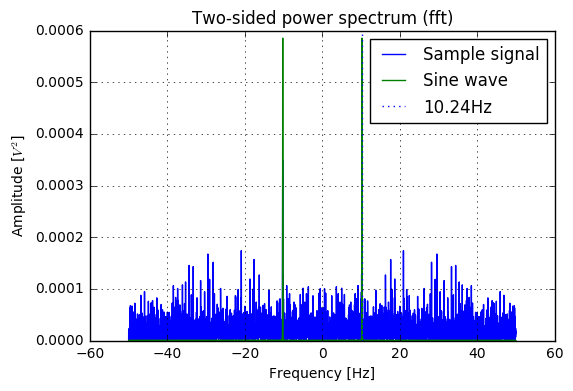

In [12]:
PS2 = [np.real(v*np.conj(v)) for v in FT2]

v = [(v[ix], freqs[ix], np.absolute(v[0])) for v in PS2 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PS2[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Two-sided power spectrum (fft)')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [$V^2$]')
ax.legend()
ax.grid()

The theoretical peak value of a sine wave two-sided normalised power spectrum is equal to the square of the sine wave two-sided normalised amplitude spectrum, that is, the square of the sine wave amplitude (A) divided by 8:

$$|S_{2-sided}| = {\left( \frac{A}{2 \cdot \sqrt 2} \right)}^2 = \frac{A^2}{8}$$

In [13]:
print(df['Max']['Sine wave'], (A**2/8))

0.000585247166579 0.0005611250000000001


The first one will be computed by mutliplying the truncated normalised rfft by their complex conjugates and applying the same scaling as for the one-sided amplitude spectra in order to obtain the **one-sided power spectra**:

                    Max       Freq            DC
Random noise   0.000347  20.922852  1.276397e-06
Sine wave      0.001170  10.229492  1.875547e-09
Sample signal  0.000698  10.229492  1.376129e-06


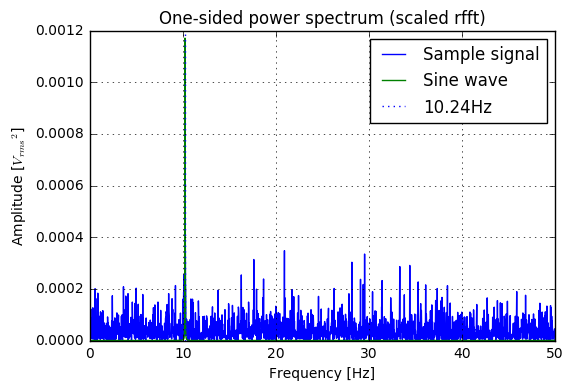

In [14]:
PS1 = [np.real(v*np.conj(v))*scale for v in TFT]

v = [(v[ix], tfreqs[ix], np.absolute(v[0])) for v in PS1 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(tfreqs, PS1[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('One-sided power spectrum (scaled rfft)')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2$]')
ax.legend()
ax.grid()

The same result can be achieved by using directly the [periodogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.periodogram.html) function implemented in SciPy:

                    Max       Freq            DC
Random noise   0.000347  20.922852  1.276397e-06
Sine wave      0.001170  10.229492  1.875547e-09
Masked signal  0.000698  10.229492  1.376129e-06


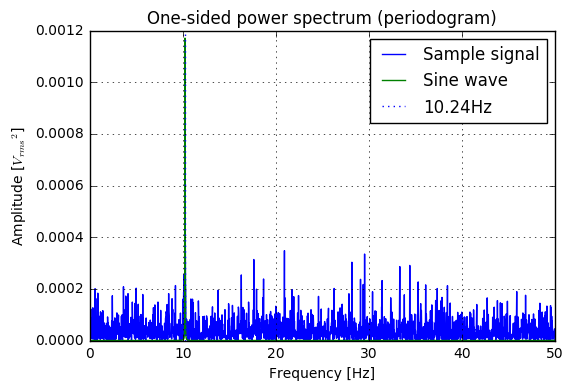

In [15]:
freqs, Prn = periodogram(rn, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Psw = periodogram(sw, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Pss = periodogram(ss, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
PS0 = (Prn, Psw, Pss)

v = [(np.absolute(v[ix]), freqs[ix], np.absolute(v[0])) for v in PS0 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PS0[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('One-sided power spectrum (periodogram)')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2$]')
ax.legend()
ax.grid()

We can see that the one-sided power spectrum estimates are the same. The peak theoretical value for a sine wave one-sided normalised power spectrum is now given by the square of the sine wave one-sided normalised amplitude spectrum, that is, the square of the sine wave amplitude (A) divided by 2:

$$|G_{1-sided}| = 2 \cdot |S_{2-sided}| = 2 \cdot \frac{A^2}{8} = \frac{A^2}{4}$$

In [16]:
print(df['Max']['Sine wave'], (A**2/4))

0.00117049433316 0.0011222500000000002


The peak corresponding to the sine wave frequency is now more visible above the major peaks in the sample signal one-sided amplitude spectrum. Let us query again for the top 5 values:

In [17]:
df = pd.DataFrame(data=np.column_stack((np.absolute(PS0[2]), tfreqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.000698  10.229492
0.000432  10.253906
0.000348  20.922852
0.000335  29.541016
0.000314  17.626953


[Back to top](#top)

## Power spectral density

More important than the power spectrum is, in our case, the power spectral density of the signal:

                    Max       Freq            DC
Random noise   0.014209  20.922852  5.228123e-05
Sine wave      0.047943  10.229492  7.682240e-08
Sample signal  0.028587  10.229492  5.636623e-05


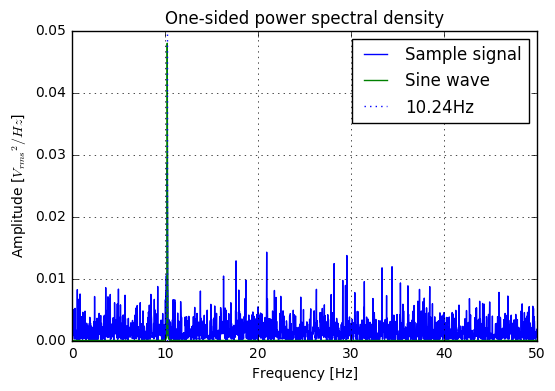

In [18]:
freqs, Prn = periodogram(rn, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Psw = periodogram(sw, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Pss = periodogram(ss, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
PSD0 = (Prn, Psw, Pss)

v = [(np.absolute(v[ix]), freqs[ix], np.absolute(v[0])) for v in PSD0 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PSD0[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('One-sided power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2/Hz$]')
ax.legend()
ax.grid()

Naturally, the peak power spectrum can be estimated from the power spectral density by multiplying by the frequency discretisation:

In [19]:
print(df['Max']['Sine wave']*(freqs[1]-freqs[0]))

0.00117049433316


The peak corresponding to the sine wave frequency is now more visible above the major peaks in the sample signal one-sided amplitude spectrum. Let us query again for the top 5 values:

In [20]:
df = pd.DataFrame(data=np.column_stack((np.absolute(PSD0[2]), tfreqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.028587  10.229492
0.017676  10.253906
0.014244  20.922852
0.013707  29.541016
0.012841  17.626953


[Back to top](#top)

## Matplotlib package

Matplotlib supplies one function, [psd](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd), to estimate the power spectral density (Pxx) of a signal (x) in the [mlab](http://matplotlib.org/api/mlab_api.html) module. This function, which is described as a "Welch’s average periodogram method", has the following signature:

    matplotlib.mlab.psd(x, NFFT=256, Fs=2, detrend=mlab.detrend_none, window=mlab.window_hanning, noverlap=0, pad_to=None,sides='default', scale_by_freq=None)

The function returns a tuple with the power spectral density estimate and the corresponding frequencies (Pxx, freqs).

                    Max       Freq            DC
Random noise   0.003859  27.929688  8.108675e-04
Sine wave      0.006020  10.156250  2.915306e-14
Sample signal  0.005814  10.156250  8.108694e-04


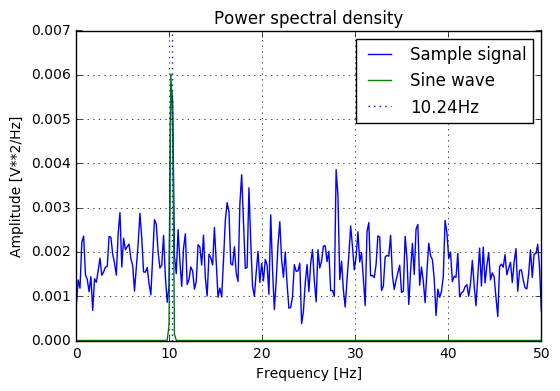

In [21]:
Prn, freqs = psd(rn, NFFT=512, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Psw, freqs = psd(sw, NFFT=512, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Pss, freqs = psd(ss, NFFT=512, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
PSD1 = (Prn, Psw, Pss)

v = [(np.absolute(v[ix]), freqs[ix], np.absolute(v[0])) for v in PSD1 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PSD1[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid()

The peak corresponding to the sine wave frequency is now more visible above the major peaks in the sample signal one-sided amplitude spectrum. Let us query again for the top 5 values:

In [22]:
df = pd.DataFrame(data=np.column_stack((np.absolute(PSD1[2]), freqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.005814  10.156250
0.005415  10.351562
0.003859  27.929688
0.003744  17.773438
0.003447  18.554688


[Back to top](#top)

## SciPy package

SciPy supplies two functions to estimate the power spectral density (Pxx) of a signal (x) in the [signal](https://scipy.github.io/devdocs/signal.html) module, [periodogram](https://scipy.github.io/devdocs/generated/scipy.signal.periodogram.html) and [welch](https://scipy.github.io/devdocs/generated/scipy.signal.welch.html). Their signatures are the following:

    scipy.signal.periodogram(x, fs=1.0, window=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

    scipy.signal.welch(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

The first function is the periodogram whereas the second function uses the Welch’s method. In the particular case that noverlap is 0, this method is equivalent to Bartlett’s method. Both functions return a tuple with the frequencies and the power spectral density estimate (freqs, Pxx).

                    Max       Freq            DC
Random noise   0.012012  18.554688  1.728472e-03
Sine wave      0.006026  10.156250  6.752403e-14
Sample signal  0.012012  18.554688  1.728450e-03


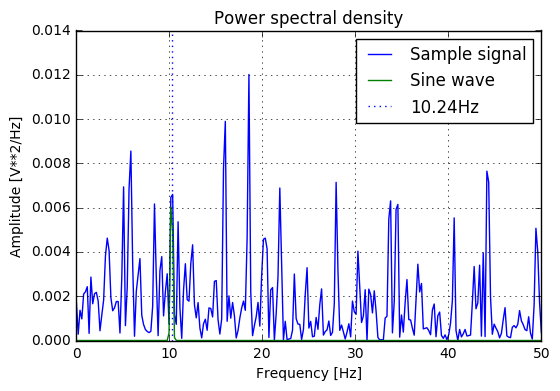

In [23]:
freqs, Prn = periodogram(rn, fs=Fs, window='hann', nfft=512, detrend=None, return_onesided=True, scaling='density', axis=-1)
freqs, Psw = periodogram(sw, fs=Fs, window='hann', nfft=512, detrend=None, return_onesided=True, scaling='density', axis=-1)
freqs, Pss = periodogram(ss, fs=Fs, window='hann', nfft=512, detrend=None, return_onesided=True, scaling='density', axis=-1)
PSD2 = (Prn, Psw, Pss)

v = [(np.absolute(v[ix]), freqs[ix], np.absolute(v[0])) for v in PSD2 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PSD2[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid()

The peak corresponding to the sine wave frequency is now more visible above the major peaks in the sample signal one-sided amplitude spectrum. Let us query again for the top 5 values:

In [24]:
df = pd.DataFrame(data=np.column_stack((np.absolute(PSD2[2]), freqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.012012  18.554688
0.009897  16.015625
0.008556   5.859375
0.007774  15.820312
0.007648  44.140625


                    Max       Freq            DC
Random noise   0.003377  20.898438  8.646122e-04
Sine wave      0.006026  10.156250  3.765853e-14
Sample signal  0.006508  10.156250  8.646169e-04


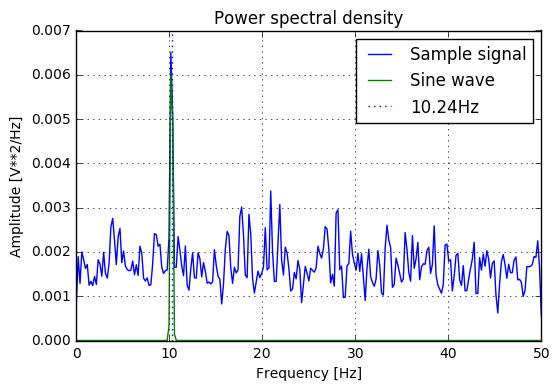

In [25]:
freqs, Prn = welch(rn, fs=Fs, window='hann', nperseg=512, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Psw = welch(sw, fs=Fs, window='hann', nperseg=512, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Pss = welch(ss, fs=Fs, window='hann', nperseg=512, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
PSD3 = (Prn, Psw, Pss)

v = [(np.absolute(v[ix]), freqs[ix], np.absolute(v[0])) for v in PSD3 for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=labels, columns=('Max', 'Freq', 'DC'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
for v in (2,1):
    ax.plot(freqs, PSD3[v], label=labels[v])
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)

The peak corresponding to the sine wave frequency is now more visible above the major peaks in the sample signal one-sided amplitude spectrum. Let us query again for the top 5 values:

In [26]:
df = pd.DataFrame(data=np.column_stack((np.absolute(PSD3[2]), freqs)), columns=('RSS', 'Freq'))
print(df.nlargest(5, columns='RSS').to_string(index=False))

RSS       Freq
0.006508  10.156250
0.005138  10.351562
0.003377  20.898438
0.003071  21.875000
0.003014  17.773438


[Back to top](#top)

## References

P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)